In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")

In [2]:
words = open("./names.txt").read().splitlines()

print(f"Number of words: {len(words)}")
print(f"Longest word: {max(words, key=len)}({max(map(len, words))})")
print(f"Shortest word: {min(words, key=len)}({min(map(len, words))})")

Number of words: 32033
Longest word: muhammadibrahim(15)
Shortest word: an(2)


In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}

g = torch.Generator().manual_seed(2147483647)

In [35]:
def plot_bigram_counts(N, itos):
    plt.figure(figsize=(16, 16))
    plt.imshow(N, cmap="Blues")
    for i in range(27):
        for j in range(27):
            chstr = itos[i] + itos[j]
            plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
            plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")
    plt.axis("off")


def get_bigram_counts(words, stoi):
    N = torch.zeros((27, 27), dtype=torch.int32)
    for w in words:
        chs = ["."] + list(w) + ["."]
        for ch1, ch2 in zip(chs, chs[1:]):
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            N[ix1, ix2] += 1
    return N


def get_bigram_probability_distribution(N, itos, smoothing=1.0):
    P = (N + smoothing).float()
    P /= P.sum(dim=1, keepdim=True)
    return P


def sample_char(p, itos, g):
    ix = torch.multinomial(p, 1, generator=g).item()
    return ix, itos[ix]


def train_bigram_model(xs, ys, epochs=10, lr=50):
    W = torch.randn((27, 27), requires_grad=True)
    for i in range(epochs):
        # compute y_pred
        xenc = F.one_hot(xs, num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdim=True)

        loss = -probs[torch.arange(xs.nelement()), ys].log().mean()

        W.grad = None
        loss.backward()

        W.data += -lr * W.grad

        if i % 10 == 0:
            print(f"loss: {loss.item():.4f}")
    return W


def generate_ngrams(words, n=2):
    assert n in [2, 3], "supported n-grams are 2 and 3"

    for word in words:
        chs = ["."] + list(word) + ["."]
        if n == 2:
            for ch1, ch2 in zip(chs, chs[1:]):
                ix1 = stoi[ch1]
                ix2 = stoi[ch2]
                yield (ix1, ix2)
        elif n == 3:
            for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
                ix1 = stoi[ch1]
                ix2 = stoi[ch2]
                ix3 = stoi[ch3]
                yield (ix1, ix2, ix3)


def create_ngram_dataset(words, n=2):
    assert n in [2, 3], "supported n-grams are 2 and 3"
    xs, ys = [], []
    for ixs in generate_ngrams(words, n):
        if n == 2:
            xs.append(ixs[0])
            ys.append(ixs[1])
        elif n == 3:
            xs.append(ixs[0] * 27 + ixs[1])
            ys.append(ixs[2])
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys


def eval_ngram_model(ngram, words, n=2):
    nll = 0
    cnt = 0
    for ixs in generate_ngrams(words, n):
        if n == 2:
            xenc = F.one_hot(torch.tensor([ixs[0]]), num_classes=27).float()
        elif n == 3:
            xenc = F.one_hot(
                torch.tensor([ixs[0] * 27 + ixs[1]]), num_classes=729
            ).float()
        logits = xenc @ ngram
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdim=True)
        if n == 2:
            nll += -probs[0, ixs[1]].log().item()
        elif n == 3:
            nll += -probs[0, ixs[2]].log().item()
        cnt += 1
    return nll / cnt


def train_trigram_model(xs, ys, device, epochs=20, lr=0.1, generator=None):
    W = torch.randn((27 * 27, 27), requires_grad=True).to(device)
    for epoch in range(epochs):
        xenc = F.one_hot(xs, num_classes=729).float().to(device)
        logits = xenc @ W
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdim=True)

        loss = -probs[torch.arange(xs.nelement()), ys].log().mean()

        W.grad = None
        loss.backward()

        W.data += -lr * W.grad

        if epoch % 10 == 0:
            print(f"loss: {loss.item():.4f}")

    return W


def sample_from_trigram(W, itos, device, g=None, bigram_model=None):
    out = []
    ix1 = 0
    if bigram_model is not None:
        # sampling the second character with a bigram model
        xenc = F.one_hot(torch.tensor([ix1]), num_classes=27).float()
        logits = xenc @ bigram_model
        counts = logits.exp()
        p = counts / counts.sum(dim=1, keepdim=True)
        ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    else:
        ix2 = 0
        # # uniform sampling of the second character
        # while True:
        #     ix2 = torch.multinomial(
        #         (torch.ones(27) / 27.0)[1:],
        #         num_samples=1,
        #         replacement=True,
        #         generator=g,
        #     ).item()
        #     if ix2 != 0:
        #         break
    out.append(itos[ix2])
    while True:

        ix = ix1 * 27 + ix2
        xenc = F.one_hot(torch.tensor([ix]), num_classes=729).float().to(device)
        logits = xenc @ W

        counts = logits.exp()
        p = counts / counts.sum(dim=1, keepdim=True)

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
        ix1 = ix2
        ix2 = ix
    return "".join(out)


def sample_from_bigram(bigram, itos, device, g=None):
    out = []
    ix = 0
    while True:

        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ bigram

        counts = logits.exp()
        p = counts / counts.sum(dim=1, keepdim=True)

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    return "".join(out)


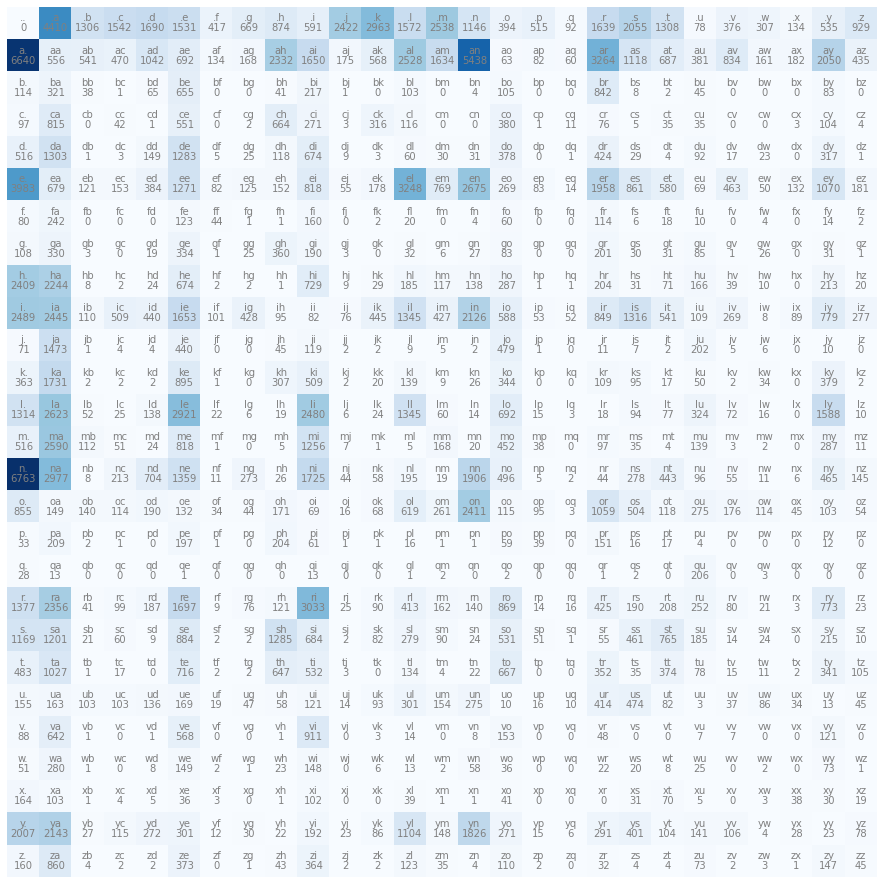

In [5]:
N = get_bigram_counts(words, stoi)
plot_bigram_counts(N, itos)

In [13]:
xs, ys = create_ngram_dataset(words, n=2)

In [14]:
bigram_model = train_bigram_model(xs, ys, epochs=100, lr=50)

loss: 3.8752
loss: 2.6871
loss: 2.5731
loss: 2.5329
loss: 2.5123
loss: 2.5001
loss: 2.4919
loss: 2.4859
loss: 2.4814
loss: 2.4778


In [28]:
nll = eval_ngram_model(bigram_model, words, n=2)
print(f'NLL of bigram model: {nll:.4f}')

NLL of bigram model: 2.4749


In [32]:
xs, ys = create_ngram_dataset(words, n=3)
trigram = train_trigram_model(xs, ys, device=device, epochs=100, lr=50, generator=g)
nll = eval_ngram_model(trigram, words, n=3)
print(f"NLL of trigram model: {nll:.4f}")


loss: 3.7648
loss: 3.1769
loss: 2.9070
loss: 2.7558
loss: 2.6569
loss: 2.5851
loss: 2.5300
loss: 2.4863
loss: 2.4508
loss: 2.4213
NLL of trigram model: 2.3963


In [34]:
# sample from bigram model
for i in range(10):
    print(sample_from_bigram(bigram_model, itos, device, g=g))

mor.
axvaninaymoryles.
kondlaisah.
anchrioy.
rie.
odaren.
iaddash.
h.
jionatien.
egwwer.


In [42]:
# sample from trigram model

print("sample using the bigram model to initialize the first two characters:\n----------------")
for i in range(10):
    print(sample_from_trigram(trigram, itos, device, g=g, bigram_model=bigram_model))

print("\nsample using '.' for the first two characters:\n----------------")
for i in range(10):
    print(sample_from_trigram(trigram, itos, device, g=g))


sample using the bigram model to initialize the first two characters:
----------------
merian.
hann.
azxbfjemnjktvza.
len.
jaodvon.
chana.
vuleelildsruittennaiositzsyn.
dande.
raybffwader.
boqkzden.

sample using '.' for the first two characters:
----------------
.zafshigzi.
.ma.
.wovrrandydjnzgidjpvcsidapdrcxrwfeoecvs.
.rqeqydgfes.
.zabellynay.
.lofhlah.
.shain.
..
.neciwedodynn.
.madpgknlctyrider.
